我们这里用单、二、三、四故障训练

In [1]:
import sys
sys.path.append('..')

In [2]:
from py_file.M_attri import Att
from py_file.Get_Data import DATA
from py_file.data_set import MyDataSet
from torch.utils.data import DataLoader,Dataset,random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [3]:
trans = transforms.Resize(224)  # ResNet模型适合的图片大小为224x244
# 输入的张量需要带着批次维度和通道维度

# 加载数据

In [4]:
attri = Att()
attri.compute_mul_defect_att()

train_data_path = '/mnt/workspace/DATA/train_WM.npz'
train_data = np.load(train_data_path)

pseudo_two_data_path = 'data_fake_label/two_fake_label_WM.npz' 
pseudo_two_data = np.load(pseudo_two_data_path)

pseudo_three_data_path = 'data_fake_label/three_fake_label_WM.npz' 
pseudo_three_data = np.load(pseudo_three_data_path)

pseudo_four_data_path = 'data_fake_label/four_fake_label_WM.npz' 
pseudo_four_data = np.load(pseudo_four_data_path)

val_data_path = '/mnt/workspace/DATA/val_WM.npz'
val_data = np.load(val_data_path)

test_data_path = '/mnt/workspace/DATA/test_WM.npz'
test_data = np.load(test_data_path)

att_dimen = len(attri.att_name)

In [5]:
# 把标签转换为对应的属性向量
train_att_vector = []
pseudo_two_att_vector = []
pseudo_three_att_vector = []
pseudo_four_att_vector = []
val_att_vector = []
test_att_vector = []

for l in train_data['label_name']:
    train_att_vector.append(attri.total_defect_att[l])
for l in pseudo_two_data['label_name']:
    pseudo_two_att_vector.append(attri.total_defect_att[l])
for l in pseudo_three_data['label_name']:
    pseudo_three_att_vector.append(attri.total_defect_att[l])
for l in pseudo_four_data['label_name']:
    pseudo_four_att_vector.append(attri.total_defect_att[l])
for l in val_data['label_name']:
    val_att_vector.append(attri.total_defect_att[l])
for l in test_data['label_name']:
    test_att_vector.append(attri.total_defect_att[l])

train_att_vector = np.array(train_att_vector)  # 因为np.array没有append方法，所以先使用list通过append添加元素，然后再将list转换为np.array
pseudo_two_att_vector = np.array(pseudo_two_att_vector)
pseudo_three_att_vector = np.array(pseudo_three_att_vector)
pseudo_four_att_vector = np.array(pseudo_four_att_vector)
val_att_vector = np.array(val_att_vector)
test_att_vector = np.array(test_att_vector)

In [6]:
train_wm = train_data['denoise_wm']
train_wm_tensor = torch.reshape(torch.tensor(train_wm, dtype=torch.float32),(len(train_wm),1,52,52))
train_att_tensor = torch.tensor(train_att_vector, dtype=torch.float32)
print(train_wm_tensor.shape, train_att_tensor.shape)

pseudo_two_wm = pseudo_two_data['denoise_wm']
pseudo_two_wm_tensor = torch.reshape(torch.tensor(pseudo_two_wm, dtype=torch.float32),(len(pseudo_two_wm),1,52,52))
pseudo_two_att_tensor = torch.tensor(pseudo_two_att_vector, dtype=torch.float32)
print(pseudo_two_wm_tensor.shape, pseudo_two_att_tensor.shape)

pseudo_three_wm = pseudo_three_data['denoise_wm']
pseudo_three_wm_tensor = torch.reshape(torch.tensor(pseudo_three_wm, dtype=torch.float32),(len(pseudo_three_wm),1,52,52))
pseudo_three_att_tensor = torch.tensor(pseudo_three_att_vector, dtype=torch.float32)
print(pseudo_three_wm_tensor.shape, pseudo_three_att_tensor.shape)

pseudo_four_wm = pseudo_four_data['denoise_wm']
pseudo_four_wm_tensor = torch.reshape(torch.tensor(pseudo_four_wm, dtype=torch.float32),(len(pseudo_four_wm),1,52,52))
pseudo_four_att_tensor = torch.tensor(pseudo_four_att_vector, dtype=torch.float32)
print(pseudo_four_wm_tensor.shape, pseudo_four_att_tensor.shape)

val_wm = val_data['denoise_wm']
val_wm_tensor = torch.reshape(torch.tensor(val_wm, dtype=torch.float32),(len(val_wm),1,52,52))
val_att_tensor = torch.tensor(val_att_vector, dtype=torch.float32)
print(val_wm_tensor.shape, val_att_tensor.shape)

test_wm = test_data['denoise_wm']
test_wm_tensor = torch.reshape(torch.tensor(test_wm, dtype=torch.float32),(len(test_wm),1,52,52))
test_att_tensor = torch.tensor(test_att_vector, dtype=torch.float32)
print(test_wm_tensor.shape, test_att_tensor.shape)

torch.Size([25910, 1, 52, 52]) torch.Size([25910, 20])
torch.Size([9100, 1, 52, 52]) torch.Size([9100, 20])
torch.Size([8400, 1, 52, 52]) torch.Size([8400, 20])
torch.Size([2800, 1, 52, 52]) torch.Size([2800, 20])
torch.Size([3700, 1, 52, 52]) torch.Size([3700, 20])
torch.Size([7405, 1, 52, 52]) torch.Size([7405, 20])


In [7]:
train_wm_tensor = trans(train_wm_tensor)  # 修改图片大小，以适应网络输入
pseudo_two_wm_tensor = trans(pseudo_two_wm_tensor)
pseudo_three_wm_tensor = trans(pseudo_three_wm_tensor)
pseudo_four_wm_tensor = trans(pseudo_four_wm_tensor)
val_wm_tensor = trans(val_wm_tensor)
test_wm_tensor = trans(test_wm_tensor)

print(train_wm_tensor.shape, train_att_tensor.shape)
print(pseudo_two_wm_tensor.shape, pseudo_two_att_tensor.shape)
print(pseudo_three_wm_tensor.shape, pseudo_three_att_tensor.shape)
print(pseudo_four_wm_tensor.shape, pseudo_four_att_tensor.shape)
print(val_wm_tensor.shape, val_att_tensor.shape)
print(test_wm_tensor.shape, test_att_tensor.shape)

torch.Size([25910, 1, 224, 224]) torch.Size([25910, 20])
torch.Size([9100, 1, 224, 224]) torch.Size([9100, 20])
torch.Size([8400, 1, 224, 224]) torch.Size([8400, 20])
torch.Size([2800, 1, 224, 224]) torch.Size([2800, 20])
torch.Size([3700, 1, 224, 224]) torch.Size([3700, 20])
torch.Size([7405, 1, 224, 224]) torch.Size([7405, 20])


In [8]:
# 转换为列表的形式，方便后续拼接
pseudo_two_wm = list(pseudo_two_wm_tensor)
pseudo_two_att = list(pseudo_two_att_tensor)
print(len(pseudo_two_wm),len(pseudo_two_att))
print(pseudo_two_wm[10].shape,pseudo_two_att[10].shape)

pseudo_three_wm = list(pseudo_three_wm_tensor)
pseudo_three_att = list(pseudo_three_att_tensor)
print(len(pseudo_three_wm),len(pseudo_three_att))
print(pseudo_three_wm[10].shape, pseudo_three_att[10].shape)

pseudo_four_wm = list(pseudo_four_wm_tensor)
pseudo_four_att = list(pseudo_four_att_tensor)
print(len(pseudo_four_wm),len(pseudo_four_att))
print(pseudo_four_wm[10].shape, pseudo_four_att[10].shape)

9100 9100
torch.Size([1, 224, 224]) torch.Size([20])
8400 8400
torch.Size([1, 224, 224]) torch.Size([20])
2800 2800
torch.Size([1, 224, 224]) torch.Size([20])


In [9]:
del pseudo_two_wm_tensor, pseudo_two_att_tensor, pseudo_three_wm_tensor, pseudo_three_att_tensor, pseudo_four_wm_tensor, pseudo_four_att_tensor

In [10]:
train_label_oh = train_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

train_single_wm = []  # 先定义列表，然后转换为tensor
train_single_att = []

train_two_wm = []
train_two_att = []

train_three_wm = []
train_three_att = []

train_four_wm = []
train_four_att = []
for i in range(len(train_label_oh)):
    if train_label_oh[i].sum() <= 1:
        train_single_wm.append(np.array(train_wm_tensor[i]))
        train_single_att.append(np.array(train_att_tensor[i]))
    elif train_label_oh[i].sum() == 2:
        train_two_wm.append(np.array(train_wm_tensor[i]))
        train_two_att.append(np.array(train_att_tensor[i]))
    elif train_label_oh[i].sum() == 3:
        train_three_wm.append(np.array(train_wm_tensor[i]))
        train_three_att.append(np.array(train_att_tensor[i]))
    elif train_label_oh[i].sum() == 4:
        train_four_wm.append(np.array(train_wm_tensor[i]))
        train_four_att.append(np.array(train_att_tensor[i]))

del train_data,train_wm_tensor,train_att_tensor

In [11]:
val_label_oh = val_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

val_single_wm = []  # 先定义列表，然后转换为tensor
val_single_att = []

val_two_wm = []
val_two_att = []

val_three_wm = []
val_three_att = []

val_four_wm = []
val_four_att = []

for i in range(len(val_label_oh)):
    if val_label_oh[i].sum() <= 1:
        val_single_wm.append(np.array(val_wm_tensor[i]))
        val_single_att.append(np.array(val_att_tensor[i]))
    elif val_label_oh[i].sum() == 2:
        val_two_wm.append(np.array(val_wm_tensor[i]))
        val_two_att.append(np.array(val_att_tensor[i]))
    elif val_label_oh[i].sum() == 3:
        val_three_wm.append(np.array(val_wm_tensor[i]))
        val_three_att.append(np.array(val_att_tensor[i]))
    elif val_label_oh[i].sum() == 4:
        val_four_wm.append(np.array(val_wm_tensor[i]))
        val_four_att.append(np.array(val_att_tensor[i]))

del val_data,val_wm_tensor,val_att_tensor

In [12]:
test_label_oh = test_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

test_single_wm = []  # 先定义列表，然后转换为tensor
test_single_att = []

test_two_wm = []
test_two_att = []

test_three_wm = []
test_three_att = []

test_four_wm = []
test_four_att = []
for i in range(len(test_label_oh)):
    if test_label_oh[i].sum() <= 1:
        test_single_wm.append(np.array(test_wm_tensor[i]))
        test_single_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 2:
        test_two_wm.append(np.array(test_wm_tensor[i]))
        test_two_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 3:
        test_three_wm.append(np.array(test_wm_tensor[i]))
        test_three_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 4:
        test_four_wm.append(np.array(test_wm_tensor[i]))
        test_four_att.append(np.array(test_att_tensor[i]))

del test_data,test_wm_tensor,test_att_tensor

In [13]:
train_wm = train_single_wm + pseudo_two_wm + pseudo_three_wm + pseudo_four_wm
train_att = train_single_att + pseudo_two_att + pseudo_three_att + pseudo_four_att

train_wm_tensor = torch.tensor(np.array(train_wm), dtype=torch.float32)
train_att_tensor = torch.tensor(np.array(train_att), dtype=torch.float32)


val_wm = val_single_wm + val_two_wm + val_three_wm + val_four_wm
val_att = val_single_att + val_two_att + val_three_att + val_four_att

val_wm_tensor = torch.tensor(np.array(val_wm), dtype=torch.float32)
val_att_tensor = torch.tensor(np.array(val_att), dtype=torch.float32)


test_wm = test_single_wm + test_two_wm + test_three_wm + test_four_wm
test_att = test_single_att + test_two_att + test_three_att + test_four_att

test_wm_tensor = torch.tensor(np.array(test_wm), dtype=torch.float32)
test_att_tensor = torch.tensor(np.array(test_att), dtype=torch.float32)

In [14]:
train_size = len(train_wm_tensor)
val_size = len(val_wm_tensor)
test_size = len(test_wm_tensor)

train_dataset = MyDataSet(train_wm_tensor,train_att_tensor)
val_dataset = MyDataSet(val_wm_tensor,val_att_tensor)
test_dataset = MyDataSet(test_wm_tensor,test_att_tensor)

print(len(train_dataset), len(val_dataset), len(test_dataset))

25910 3700 7405


In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader),len(val_loader),len(test_loader))

405 116 232


In [16]:
del train_wm_tensor,train_att_tensor
del val_wm_tensor,val_att_tensor
del test_wm_tensor,test_att_tensor

# 定义模型

In [17]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# 替换第一个卷积以适应我们的单通道图像
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# 替换最后的全连接层以适配我们的属性输出
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(attri.att_name))
model.add_module('sigmoid', nn.Sigmoid())
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# 定义训练的设备
if torch.cuda.is_available():
    device = torch.device('cuda:0') # 只有一张显卡的话，'cuda'和'cuda:0'是一样的
else:
    device = torch.device('cpu')
print(f'使用的设备为：{device}')

使用的设备为：cuda:0


In [19]:
from py_file.func_Test import Test_Func
# 需要的函数都已经集成在了Test_Func里
func = Test_Func()

# 开始训练

In [20]:
model = model.to(device)
loss_func = nn.MSELoss().to(device=device)
learning_rate = 1e-2  # 0.01
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [21]:
# 添加正则化项
def regularization_loss(model, lambda_reg):
    l2_reg = 0
    for param in model.parameters():
        l2_reg += torch.norm(param) ** 2  # 计算L2范数的平方
    return lambda_reg * l2_reg

In [22]:
epochs = 50  # 训练迭代的次数，一个epoch把训练集过一遍
lambda_reg = 0.01  # 正则化强度

In [23]:
import time
best_acc = 0
No = 0
for i in range(epochs):
    # total_train_steps = 0
    print(f'————第{i+1}轮训练开始————')

    model.train()   # 开始训练
    total_train_loss = 0
    start_time = time.time()
    for imgs,labels in train_loader:

        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        # print(outputs)
        loss = loss_func(outputs, labels) + regularization_loss(model, lambda_reg)
        total_train_loss = total_train_loss + loss.item()

        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()
    print(f'训练时间为：{end_time-start_time}, 总Loss:{total_train_loss}')  # loss是一个tensor数据类型，loss.item()是一个浮点数数据类型
    print(f'****第{i+1}轮训练结束****')


    # 验证步骤开始
    model.eval()   # 开始验证
    total_val_loss = 0
    # with的作用是可以确保代码块执行完毕后，资源被正确释放，也就是使用with，在执行完外码块之后，它会自动地关闭所打开的内容
    # 例如关闭文件、释放线程锁等
    with torch.no_grad():   # 这里要进行验证，不需要修改参数，所以不计算梯度
        for data_v in val_loader:  
            imgs,labels = data_v

            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            # 计算损失
            loss = loss_func(outputs,labels)
            total_val_loss = total_val_loss+loss.item()  # loss是一个tensor数据类型，loss.item()是一个浮点数数据类型

    # 计算准确率
    acc = func.get_acc(model,val_loader,attri.total_defect_att,val_size,'cos')
    print(f'第{i+1}轮训练后,整体验证集上的Loss:{total_val_loss}')
    print(f'第{i+1}轮训练后,整体验证集上的Accuracy:{acc}')
    if acc > best_acc:  # 我们在这里保存准确率最高的模型
        best_acc = acc
        No = i+1
        torch.save(obj=model,f='model_saved_pseudo/train_all.pth')

print(f'训练结束，第{No}轮的模型在验证集上准确率最高，为{best_acc}')


————第1轮训练开始————
训练时间为：28.23004937171936, 总Loss:26658.790088653564
****第1轮训练结束****
第1轮训练后,整体验证集上的Loss:8.742825939320028
第1轮训练后,整体验证集上的Accuracy:0.46837837837837837
————第2轮训练开始————
训练时间为：25.17689323425293, 总Loss:22660.632122039795
****第2轮训练结束****
第2轮训练后,整体验证集上的Loss:7.69609265960753
第2轮训练后,整体验证集上的Accuracy:0.5875675675675676
————第3轮训练开始————
训练时间为：25.1828351020813, 总Loss:19271.454921722412
****第3轮训练结束****
第3轮训练后,整体验证集上的Loss:6.687794511206448
第3轮训练后,整体验证集上的Accuracy:0.6008108108108108
————第4轮训练开始————
训练时间为：25.192487478256226, 总Loss:16390.63161468506
****第4轮训练结束****
第4轮训练后,整体验证集上的Loss:5.647337376140058
第4轮训练后,整体验证集上的Accuracy:0.7064864864864865
————第5轮训练开始————
训练时间为：25.18515682220459, 总Loss:13941.052656173706
****第5轮训练结束****
第5轮训练后,整体验证集上的Loss:5.294318964704871
第5轮训练后,整体验证集上的Accuracy:0.7470270270270271
————第6轮训练开始————
训练时间为：25.192424297332764, 总Loss:11858.042915344238
****第6轮训练结束****
第6轮训练后,整体验证集上的Loss:5.1050385581329465
第6轮训练后,整体验证集上的Accuracy:0.73
————第7轮训练开始————
训练时间为：25.18699049949646, 总Loss:

# 开始测试

In [24]:
model = torch.load('model_saved_pseudo/train_all.pth')
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
test_single_wm_tensor = torch.tensor(np.array(test_single_wm), dtype=torch.float32)
test_single_att_tensor = torch.tensor(np.array(test_single_att), dtype=torch.float32)

test_two_wm_tensor = torch.tensor(np.array(test_two_wm), dtype=torch.float32)
test_two_att_tensor = torch.tensor(np.array(test_two_att), dtype=torch.float32)

test_three_wm_tensor = torch.tensor(np.array(test_three_wm), dtype=torch.float32)
test_three_att_tensor = torch.tensor(np.array(test_three_att), dtype=torch.float32)

test_four_wm_tensor = torch.tensor(np.array(test_four_wm), dtype=torch.float32)
test_four_att_tensor = torch.tensor(np.array(test_four_att), dtype=torch.float32)

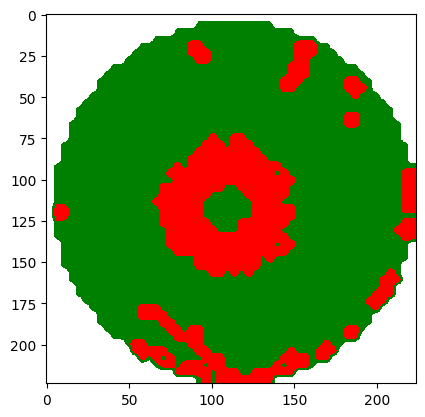

预测的属性向量tensor([-0.0058,  1.0587,  0.8064,  0.7614,  1.0901,  0.9573,  0.8626,  0.9790,
         1.2164, -0.0241, -0.0013,  0.0055,  1.0071,  1.2495,  1.0169,  1.0134,
         0.8628,  0.9762,  0.2192,  1.1007], device='cuda:0')
真实的属性向量tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1.])
真实标签为：D+EL+L+S
欧式距离计算的标签为：D+EL+L+S
余弦相似度计算的标签为：D+EL+L+S


In [26]:
func.show_result(model, test_four_wm_tensor, test_four_att_tensor, attri.four_defect_att)

In [27]:
test_single_dataset = MyDataSet(test_single_wm_tensor,test_single_att_tensor)
test_single_loader = DataLoader(test_single_dataset, batch_size=32, shuffle=False)

test_two_dataset = MyDataSet(test_two_wm_tensor,test_two_att_tensor)
test_two_loader = DataLoader(test_two_dataset, batch_size=32, shuffle=False)

test_three_dataset = MyDataSet(test_three_wm_tensor,test_three_att_tensor)
test_three_loader = DataLoader(test_three_dataset, batch_size=32, shuffle=False)

test_four_dataset = MyDataSet(test_four_wm_tensor,test_four_att_tensor)
test_four_loader = DataLoader(test_four_dataset, batch_size=32, shuffle=False)

In [28]:
print(func.get_acc(model, test_single_loader, attri.single_defect_att, len(test_single_dataset), 'cos'))
print(func.get_acc(model, test_two_loader, attri.two_defect_att, len(test_two_dataset), 'cos'))
print(func.get_acc(model, test_three_loader, attri.three_defect_att, len(test_three_dataset), 'cos'))
print(func.get_acc(model, test_four_loader, attri.four_defect_att, len(test_four_dataset), 'cos'))
print(func.get_acc(model, test_loader, attri.total_defect_att, len(test_dataset), 'cos'))

0.9570093457943926
0.9653846153846154
0.9225
0.89125
0.8926401080351114
